# Attention couple
latent couple (two shot diffusion)の発展版です。機能自体はlatent coupleと同じですが、latent coupleに比べて高速に生成できる（はず）。さらにクオリティもあがる（といいなあ・・・）。

参考：latent couple (two shot diffusion)

https://note.com/kizamimi/n/nab766a7484fe

In [1]:
#diffusers==0.11以降のcross attentionはよくわかんない
!pip install diffusers==0.10.2 transformers accelerate safetensors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.1/503.1 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.6 MB/s eta 0:00:00


In [2]:
!pip install xformers triton

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 KB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=90004 sha256=be277bf22471005f0e22c236cfb499f8920ce1e281e1048b9e098e371aeafda5
  Stored in directory: /root/.cache/pip/wheels/b7/68/18/2ad49b416abb9139c8217c349fd9df0674da8f0d1952db2ea5
Successfully built lit


In [3]:
#実装をわかりやすくするためのシンプルな画像生成パイプラインです
#()[]やトークン長の拡張・CLIP skipはありません。
#samplerもDDIMのみ

import torch
from diffusers import AutoencoderKL, DDIMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm


class AttentionCoupleGenerator:
    def __init__(self,model_id, dtype=torch.float32, device="cuda"):

        self.tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder='tokenizer')
        self.text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder='text_encoder').eval().to(device, dtype=dtype)
        
        self.vae = AutoencoderKL.from_pretrained(model_id, subfolder='vae').eval().to(device, dtype=dtype)
        self.vae.enable_slicing()
    
        self.unet = UNet2DConditionModel.from_pretrained(model_id, subfolder='unet').eval().to(device, dtype=dtype)
        self.unet.set_use_memory_efficient_attention_xformers(True)

        self.scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

        self.dtype = dtype
        self.device = device

        self.hook_forwards(self.unet) #Cross Attention書き換え

    def encode_prompts(self, prompts):
        '''
        プロンプトをとーくんにしてtext_encoderの隠れ状態を出力する。
        promptsはリストであることを前提とする。
        '''
        with torch.no_grad():
            tokens = self.tokenizer(prompts, max_length=self.tokenizer.model_max_length, padding=True, truncation=True, return_tensors='pt').input_ids.to(self.device)
            embs = self.text_encoder(tokens, output_hidden_states=True).last_hidden_state.to(self.device, dtype = self.dtype)
        return embs

    #潜在変数からPillowに変換
    def decode_latents(self, latents):
        latents = 1 / 0.18215 * latents
        with torch.no_grad():    
            images = self.vae.decode(latents).sample
        images = (images / 2 + 0.5).clamp(0, 1)
        images = images.cpu().permute(0, 2, 3, 1).float().numpy()
        images = (images * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images

    def __call__(self,prompts, negative_prompt, batch_size = 4, height:int = 512, width:int = 512, guidance_scale:float = 7.0, num_inference_steps:int = 50, twoshot_weight=0.8, end_steps:float = 1):
        '''
        prompts: 基本プロンプト、左プロンプト、右プロンプトの順番
        '''

        self.twoshot_weight = twoshot_weight
        #[main*b,left*b,right*b,neg*b] chunkで分けやすいように
        all_prompts = []
        for prompt in prompts:
            all_prompts.extend([prompt] * batch_size)
        all_prompts.extend([negative_prompt] * batch_size)

        #プロンプト、ネガティブプロンプトのtext_encoder出力
        text_embs = self.encode_prompts(all_prompts)

        #スケジューラーのtimestepを設定
        self.scheduler.set_timesteps(num_inference_steps, device=self.device)
        timesteps = self.scheduler.timesteps

        #初期ノイズ
        latents = torch.randn(batch_size, 4, height // 8, width // 8).to(self.device, dtype = self.dtype)
        latents = latents * self.scheduler.init_noise_sigma

        self.height = height // 8
        self.width = width // 8
        self.pixels = self.height * self.width 

        progress_bar = tqdm(range(num_inference_steps), desc="Total Steps", leave=False)

        self.couple = True
        for i,t in enumerate(timesteps):
            #入力を作成
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            #attention_coupleの終了条件
            if i > num_inference_steps * end_steps and self.couple:
                cond, _, _, negative = text_embs.chunk(4)
                text_embs = torch.cat([cond,negative])
                self.couple = False
            
            #推定ノイズ
            with torch.no_grad():
                noise_pred = self.unet(sample = latent_model_input,timestep = t,encoder_hidden_states=text_embs).sample

            #ネガティブプロンプト版CFG
            noise_pred_text, noise_pred_negative= noise_pred.chunk(2)
            noise_pred = noise_pred_negative + guidance_scale * (noise_pred_text - noise_pred_negative)

            #推定ノイズからノイズを取り除いたlatentsを求める
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

            progress_bar.update(1)
        
        images = self.decode_latents(latents)
        return images

    def hook_forward(self, module):
        #diffusers==0.10.2
        def forward(hidden_states, context=None, mask=None):
            batch_size, sequence_length, _ = hidden_states.shape

            query = module.to_q(hidden_states)

            #copy query
            if self.couple:
                #(q_cond, q_uncond) -> (q_cond,q_cond,q_cond,q_uncond)
                query_cond , query_uncond = query.chunk(2)
                query = torch.cat([query_cond, query_cond, query_cond, query_uncond])

            context = context if context is not None else hidden_states
            key = module.to_k(context)
            value = module.to_v(context)

            dim = query.shape[-1]

            query = module.reshape_heads_to_batch_dim(query)
            key = module.reshape_heads_to_batch_dim(key)
            value = module.reshape_heads_to_batch_dim(value)

            # TODO(PVP) - mask is currently never used. Remember to re-implement when used

            # attention, what we cannot get enough of
            if module._use_memory_efficient_attention_xformers:
                hidden_states = module._memory_efficient_attention_xformers(query, key, value)
                # Some versions of xformers return output in fp32, cast it back to the dtype of the input
                hidden_states = hidden_states.to(query.dtype)
            else:
                if module._slice_size is None or query.shape[0] // module._slice_size == 1:
                    hidden_states = module._attention(query, key, value)
                else:
                    hidden_states = module._sliced_attention(query, key, value, sequence_length, dim)

            #cond * (1-w) + [left right] * w
            if self.couple:
                rate = int((self.pixels // query.shape[1]) ** 0.5) #down sampleの割合を確認
                
                height = self.height // rate
                width = self.width // rate

                
                cond, left, right, uncond = hidden_states.chunk(4)
                
                #画像の形に変換
                left = left.reshape(left.shape[0],  height, width, left.shape[2])
                right = right.reshape(right.shape[0],  height, width, right.shape[2])

                #左右を分割して合体
                couple = torch.cat([left[:,:,:width//2,:], right[:,:,width//2:,:]], dim=2)
                couple = couple.reshape(cond.shape[0], -1,  cond.shape[2])

                #重みづけ和
                cond = cond * (1 - self.twoshot_weight) + couple * self.twoshot_weight

                #uncondをくっつけておわり
                hidden_states = torch.cat([cond,uncond])

            # linear proj
            hidden_states = module.to_out[0](hidden_states)
            # dropout
            hidden_states = module.to_out[1](hidden_states)

            return hidden_states

        return forward
    
    #名前が分かりづらい
    def hook_forwards(self, root_module: torch.nn.Module):
        for name, module in root_module.named_modules():
            if "attn2" in name and module.__class__.__name__ == "CrossAttention":
                module.forward = self.hook_forward(module)

    

In [5]:
model_id = "hakurei/waifu-diffusion" #多分変わらんと思うけどSD2.x系しか確認してません
pipe = AttentionCoupleGenerator(model_id,dtype = torch.float16)

In [45]:
prompt = [
    "masterpiece, best quality, 2girls",
    "masterpiece, best quality, 2girls, black hair, red eyes, school uniform, blue sailor collar, blue skirt",
    "masterpiece, best quality, 2girls, white hair, blue eyes, maid, maid headdress, skirt",
]
negative_prompt = "worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"

In [48]:
images = pipe(prompt,negative_prompt,
              batch_size = 4, #一度に生成する画像数
              num_inference_steps=28, #sampling step数
              height = 896, 
              width = 640, 
              end_steps = 1, #attention coupleを終了するステップ数(0～1の割合で指定、1なら全ステップでattention coupleを適用、0は普通の生成になる)
              twoshot_weight=1 #左右プロンプトの重み、0で基本プロンプトのみで生成、1で基本プロンプトを無視して生成
              )    

Total Steps:   0%|          | 0/28 [00:00<?, ?it/s]

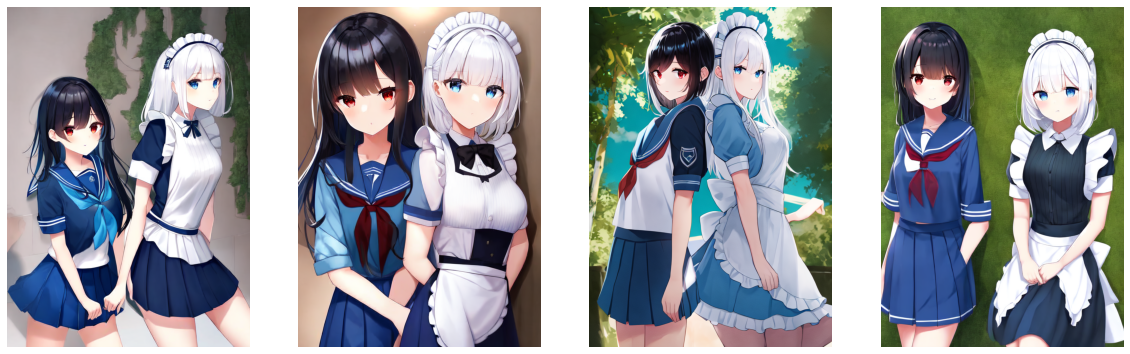

In [50]:
import matplotlib.pyplot as plt
import math
plt.figure(figsize=(20,20))
for i,image in enumerate(images):
    plt.subplot(math.ceil(len(images)/4),4,i+1)
    plt.imshow(np.array(image))
    plt.axis('off')